# Task3. 酶的EC号预测

> author: Shizhenkun   
> email: zhenkun.shi@tib.cas.cn   
> date: 2021-06-03  

## 任务简介
该任务通过给定酶序列，预测该酶的反应类别（EC号）


## 数据统计
- 遵照任务1找到的时间节点对数据进行划分
- 以2009年12月14日为时间节点，之前的数据为训练集，之后的数据为测试集，具体数据集统计如下： 


|     Items    | 单功能酶       |   多功能非酶    |合计                     |
| ------------ | --------| --------- |----------------------------------|
| 训练集        | 185,453 | 13,239    | 198,692（198,692/219,227=90.63%) |
| 测试集        | 18,868  | 25,594    | 20,535 (20,535/219,227=9.37% )   |


## 数据集构建方法

* 根据蛋白注释信息与之前划定的酶与非酶数据集，将「酶」数据进行分类。
* 有1个EC号的被定义为「单功能酶」，有多个EC号的被定义为「多功能酶」。
* EC号数目：4676个


## 实验结果

### Baselines

|Methods   | Accuracy                        |             Precision           |           Recall               |F1   |
| ---------| ------------------------------- | ------------------------------- |--------------------------------|-----|
| 同源比对  |  0.6345134619461522(11972/18868) | 0.7470360663921128(11972/16026) |0.84937460250159(16026/18868)   |      |
| DeepEC<sup style='color:red'>[DeepEC, 2019]</sup>   |  0.5264468942124232(9933/18868)| 0.7691056910569106(9933/12915) |0.6844922620309519(12915/18868)   |      |





[1. DeepEC, 2019](https://bitbucket.org/kaistsystemsbiology/deepec/src/master/) </br>
<span style='color:red'>Ryu, Jae Yong, Hyun Uk Kim, and Sang Yup Lee. "Deep learning enables high-quality and high-throughput prediction of enzyme commission numbers." Proceedings of the National Academy of Sciences 116.28 (2019): 13996-14001.</span>

[2. ECpred, 2018](https://ecpred.kansil.org/)

<span style='color:red'>Dalkiran, A., Rifaioglu, A. S., Martin, M. J., Cetin-Atalay, R., Atalay, V., & Doğan, T. (2018). ECPred: a tool for the prediction of the enzymatic functions of protein sequences based on the EC nomenclature. BMC bioinformatics, 19(1), 334. </span>

[3. EzyPred, 2007](http://www.csbio.sjtu.edu.cn/bioinf/EzyPred/#) 

<span style='color:red'>Shen, Hong-Bin, and Kuo-Chen Chou. "EzyPred: a top–down approach for predicting enzyme functional classes and subclasses." Biochemical and biophysical research communications 364.1 (2007): 53-59. </span>

[4. SVM-Prot, 2016](http://bidd.group/cgi-bin/svmprot/) [[速度奇慢]]

<span style='color:red'>Li, Ying Hong, et al. "SVM-Prot 2016: a web-server for machine learning prediction of protein functional families from sequence irrespective of similarity." PloS one 11.8 (2016): e0155290. </span>

## 前期实验结果分析

> ECpred 分析

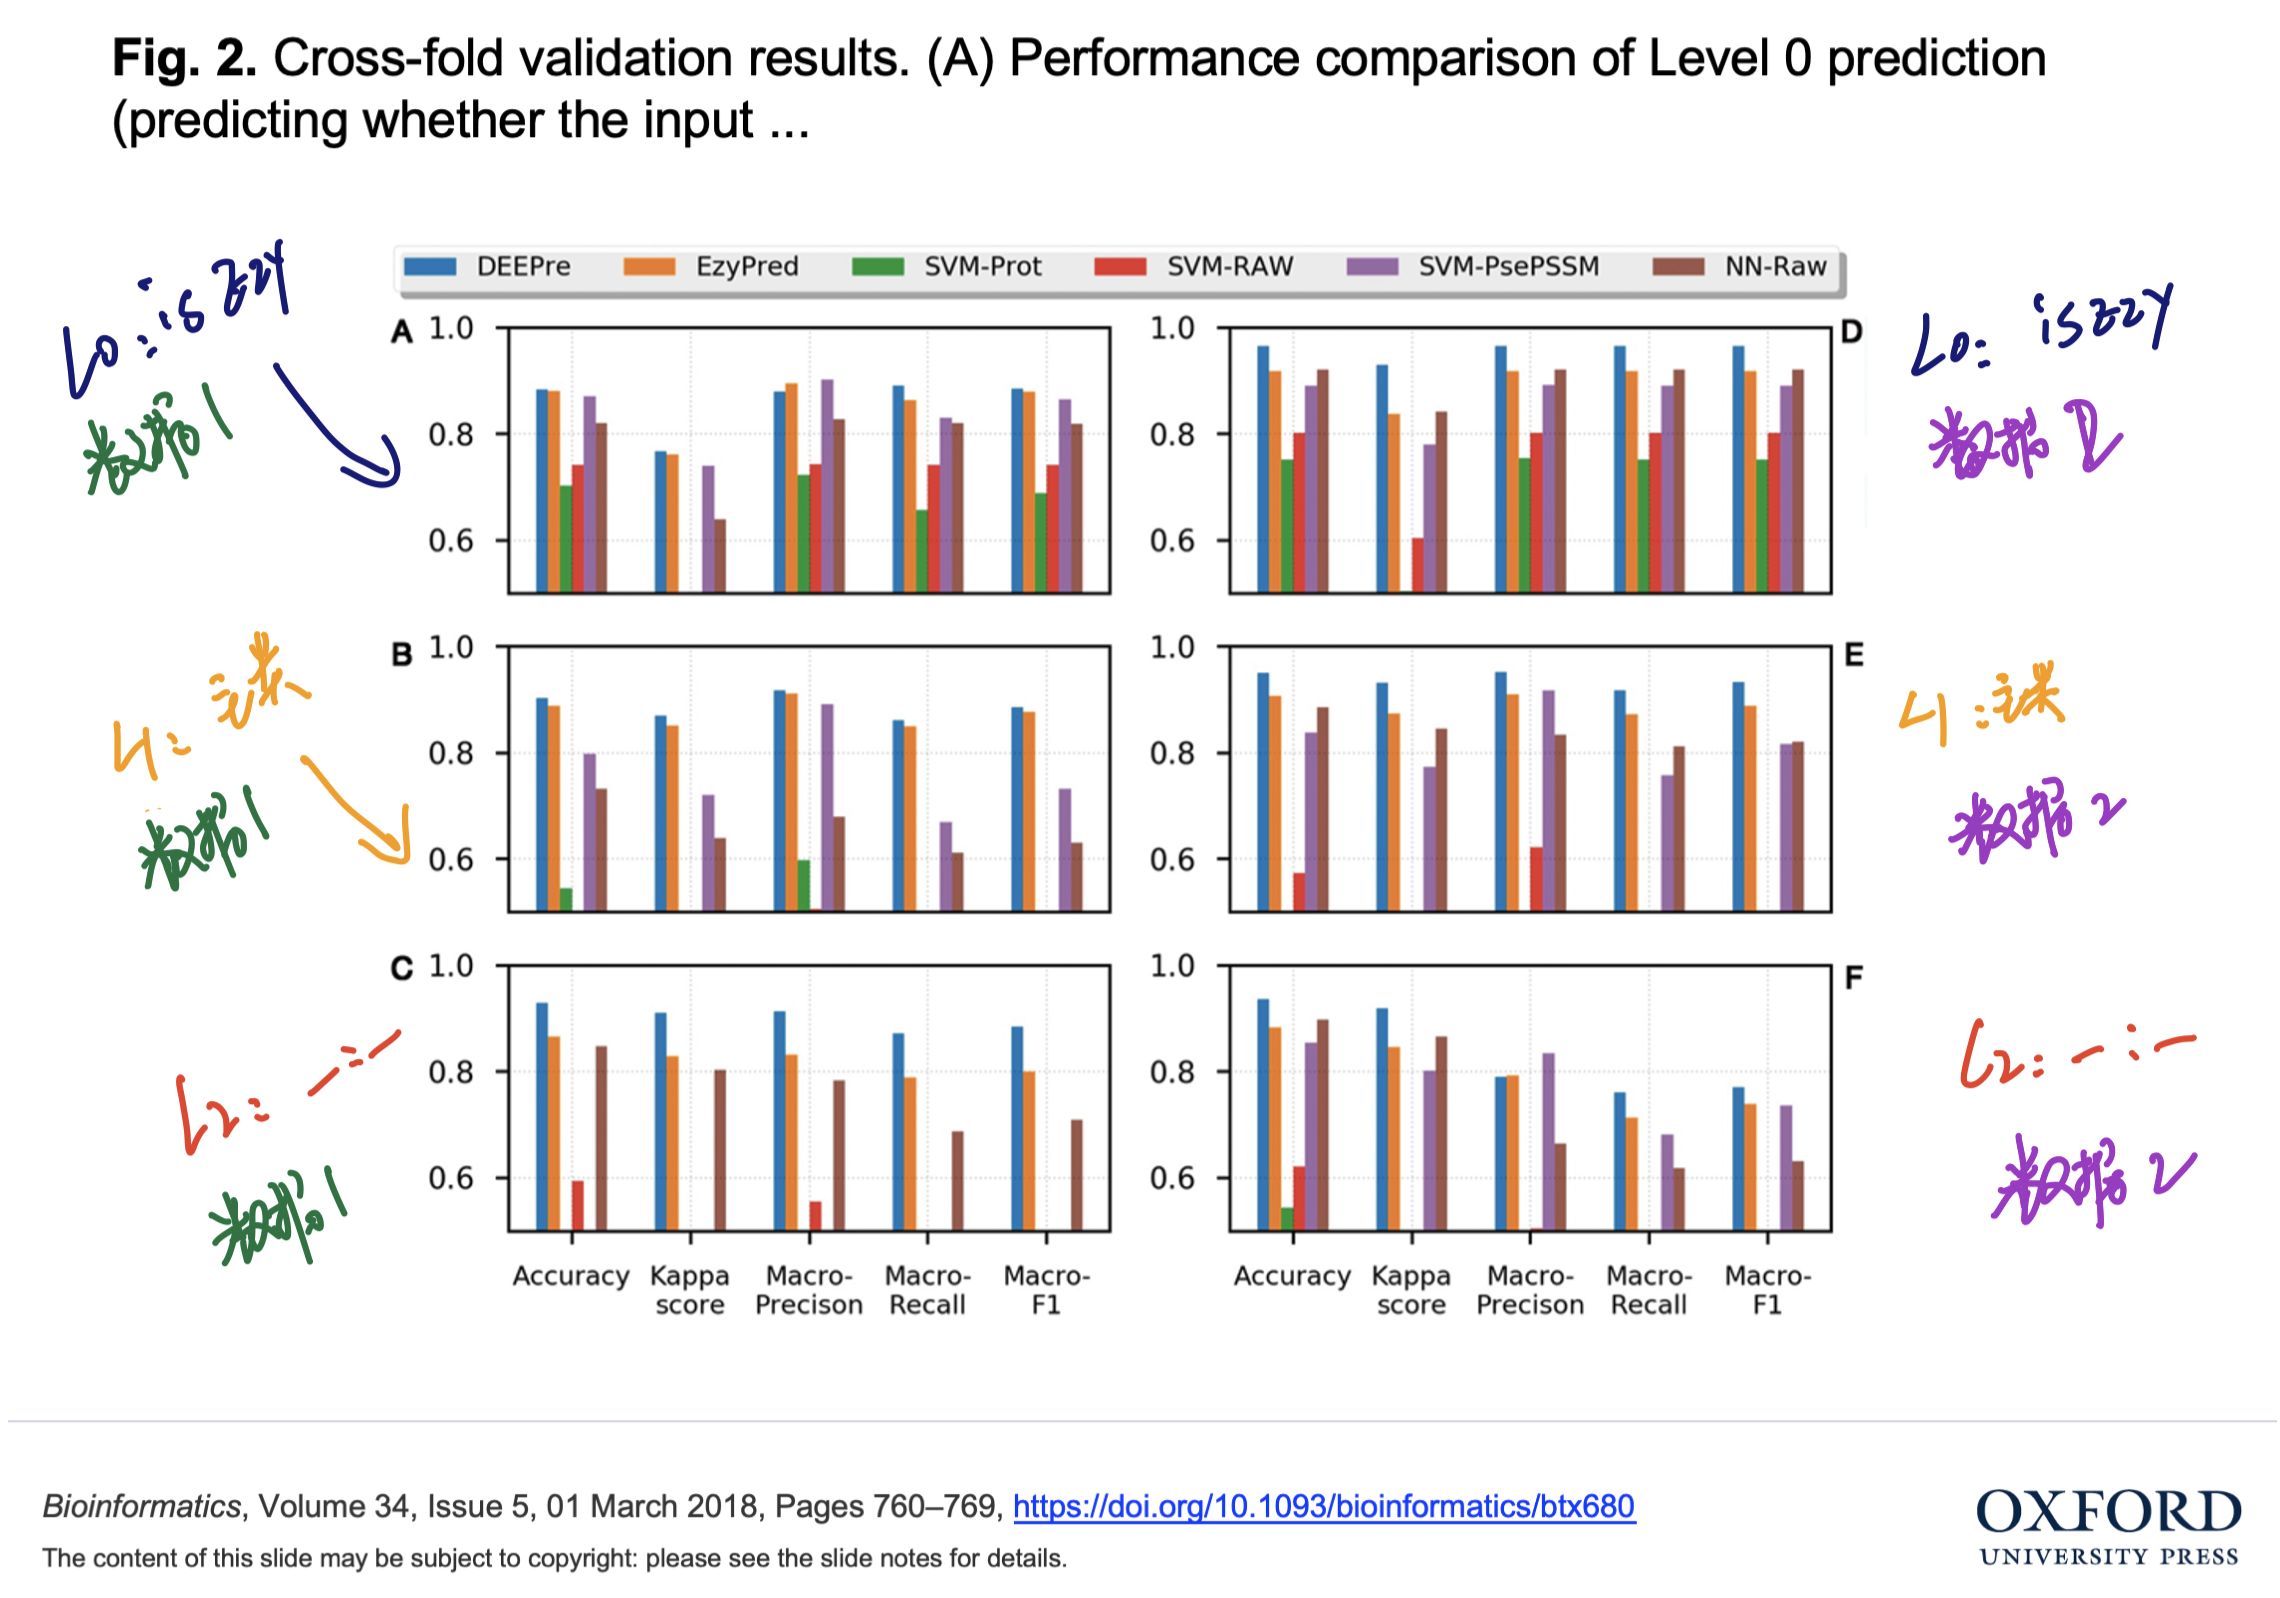




> DeepEc 分析


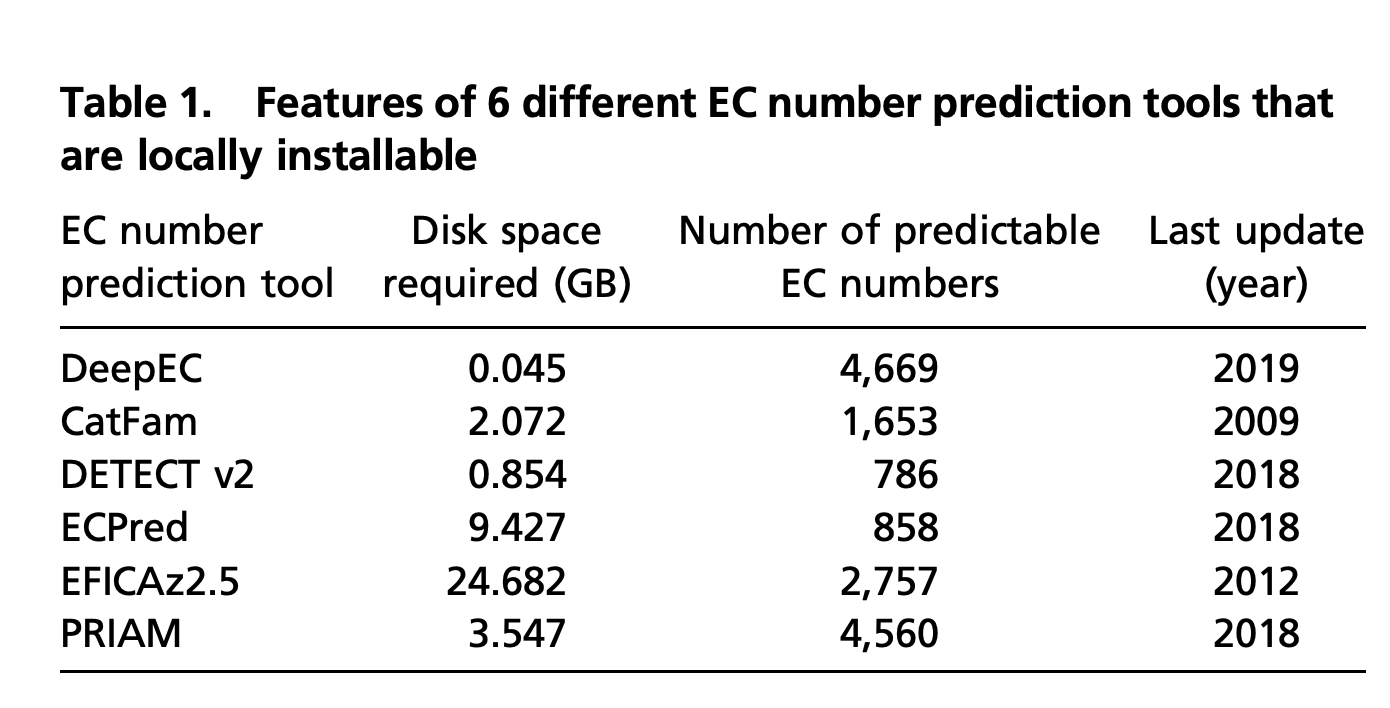


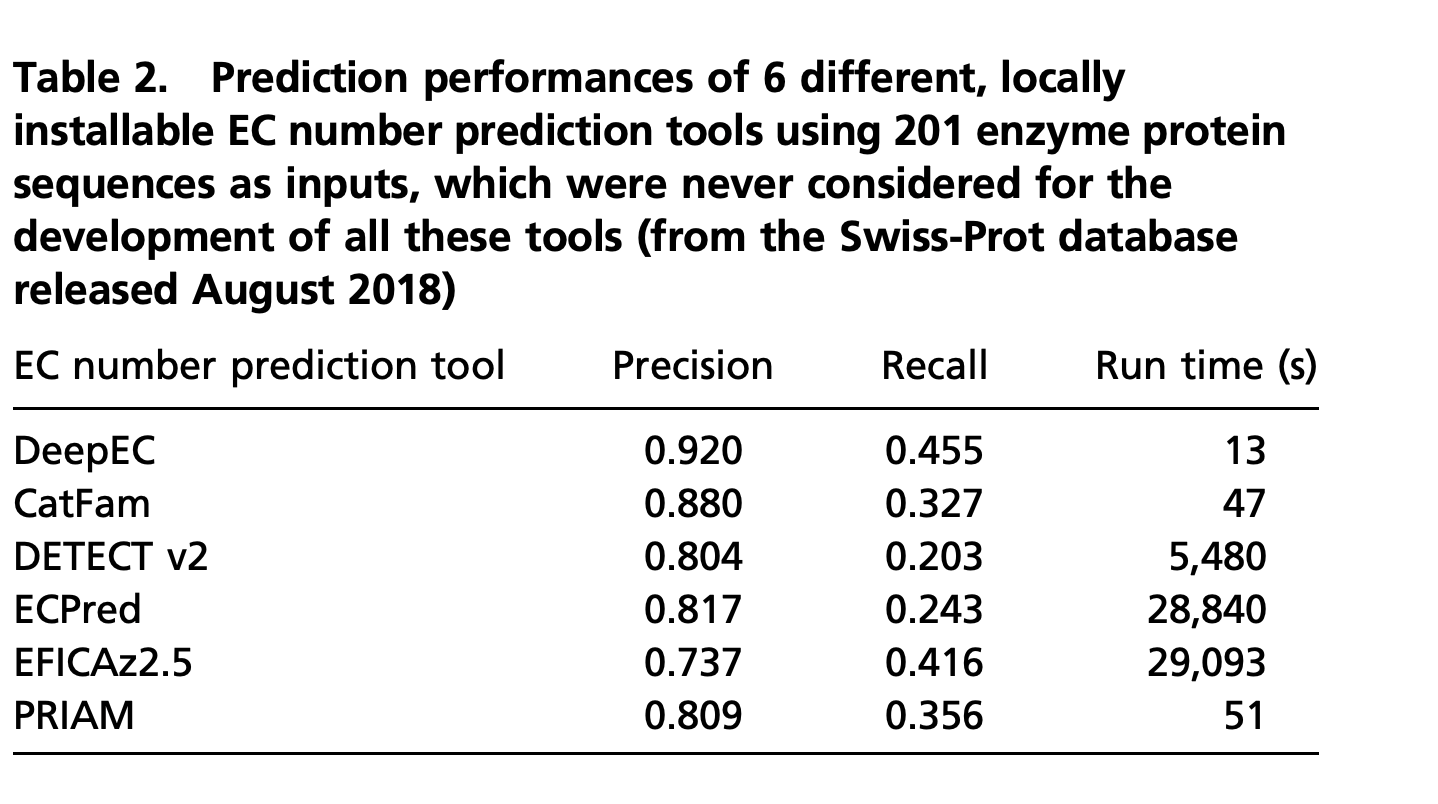

### 机器学习 + onehot


|baslineName| accuracy 	 |precision(PPV) |	 NPV 	 |	recall |	f1 	 |	 auroc 	 |	 auprc 	 |	 confusion Matrix					|
| ------| ----------|-----------| ---------- | ----------|-----------|-----------|---------- |------------------------------------------|





### 机器学习 + unirep

|baslineName| accuracy 	 |precision(PPV) |	 NPV 	 |	recall |	f1 	 |	 auroc 	 |	 auprc 	 |	 confusion Matrix					    |
| ----------| -----------|---------------| --------- | --------|---------|-----------|---------- |------------------------------------------|



## 1. 导入必要的包

In [2]:
import numpy as np
import pandas as pd
import random
import sys
from tqdm import tqdm
sys.path.append("../../tools/")
import commontools
import funclib

from xgboost.sklearn import XGBClassifier


%load_ext autoreload
%autoreload 2

## 2. 加载数据

In [7]:
train = pd.read_hdf('./data/train.h5',key='data')
test = pd.read_hdf('./data/test.h5',key='data')
head = funclib.table_head + ['f'+str(i) for i in range(1, 1901) ]
head = head + ['ec_label','ec_appears']
train.columns = head
test.columns = head

## 3. 同源比对

In [43]:
res_data=funclib.getblast(train,test)

Write finished
Write finished
diamond makedb --in /tmp/train.fasta -d /tmp/train.dmnd
diamond blastp -d /tmp/train.dmnd  -q  /tmp/test.fasta -o /tmp/test_fasta_results.tsv -b5 -c1 -k 1


In [51]:
# 匹配查询结果
id_map_ec = train[['id', 'ec_number']].append(test[['id', 'ec_number']],ignore_index=True)
id_ec_dict = {v: k for v,k in zip( id_map_ec.id, id_map_ec.ec_number)} 
res_data['is_ec_match']=res_data.apply(lambda x: (id_ec_dict.get(x['id'])== id_ec_dict.get(x['sseqid'])), axis=1)

# 输出比对结果
funclib.evaluateBlast(res_data,train,test, 'ec_number')

Total query records are: 18868
Matched records are: 16026
Accuracy: 0.6345134619461522(11972/18868)
Pricision: 0.7470360663921128(11972/16026)
Recall: 0.84937460250159(16026/18868)


## 4. DeepEC

In [55]:
funclib.table2fasta(test, './data/deepec.fasta')
! python ../../baselines/deepec/deepec.py -i ./data/deepec.fasta -o ./data/deepec/

Write finished


In [24]:
# 读取预测结果
deepec_results = pd.read_csv('./data/deepec/DeepEC_Result.txt', sep='\t',names=['id', 'ec_number'], header=0) #读入文件
deepec_results.ec_number=deepec_results.apply(lambda x: x['ec_number'].replace('EC:',''), axis=1)

In [20]:
# 计算指标
ec_dict = {v: k for k,v in zip(test.ec_number, test.id )} 
deepec_results['ec_groundtruth'] = deepec_results.apply(lambda x: ec_dict.get(x['id']), axis=1)
deepec_results['iscorrect'] = deepec_results.apply(lambda x: x.ec_number == x.ec_groundtruth, axis=1)

correct = sum(deepec_results['iscorrect'])
find  = len(deepec_results)
total = len(test)
print('Total query records are: {0}'.format(total))
print('Matched records are: {0}'.format(find))
print('Accuracy: {0}({1}/{2})'.format(correct/total, correct, total))
print('Pricision: {0}({1}/{2})'.format(correct/find, correct, find))
print('Recall: {0}({1}/{2})'.format(find/total, find, total))

## 5. 机器学习EC号预测
### 5.1 onehot + 机器学习

In [4]:
trainset = train[['id', 'ec_label','seq', 'seqlength']].reset_index(drop=True)
testset = test[['id', 'ec_label','seq', 'seqlength']].reset_index(drop=True)

MAX_SEQ_LENGTH = 1000 #定义序列最长的长度
trainset.seq = trainset.seq.map(lambda x : x[0:MAX_SEQ_LENGTH].ljust(MAX_SEQ_LENGTH, 'X'))
testset.seq = testset.seq.map(lambda x : x[0:MAX_SEQ_LENGTH].ljust(MAX_SEQ_LENGTH, 'X'))

f_train = funclib.dna_onehot(trainset) #训练集编码
f_test = funclib.dna_onehot(testset) #测试集编码

train_full = pd.concat([trainset, f_train], axis=1, join='inner' ) #拼合训练集
test_full = pd.concat([testset, f_test], axis=1, join='inner' )    #拼合测试集

X_train = np.array(train_full.iloc[:,4:])
X_test = np.array(test_full.iloc[:,4:])
Y_train = np.array(train_full.ec_label.astype('int'))
Y_test = np.array(test_full.ec_label.astype('int'))



In [7]:
xgboost_clf = XGBClassifier(min_child_weight=6,max_depth=15, objective='multi:softmax',num_class=5, n_jobs=-2)
print("-" * 60)
print("xgboost模型：", xgboost_clf)
clf = xgboost_clf.fit(X_train, Y_train)
res = clf.predict(X_test)
aa = pd.DataFrame()
aa['ground_truth'] = Y_test
aa['pred'] = res
aa['iscorrect']= aa.apply(lambda x: x.ground_truth == x.pred, axis=1)
aa.iscorrect.sum()

------------------------------------------------------------
xgboost模型： XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=15,
              min_child_weight=6, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=-2, num_class=5, num_parallel_tree=None,
              objective='multi:softmax', random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None)
[18:33:00] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if 

In [38]:
print(test.seq.iloc[2])

MNTLTTYLVIAAVLFCLGLLGILQRRNLVGMLISLELMLNGANLNFMAFNRFLAPEPAVGQIIALIVMGLAAAEAAIGLSIIFALFRRMHSINVERAQELRG


In [34]:
tasks/task3/data/deepec.fasta

,id,name,isemzyme,isMultiFunctional,functionCounts,ec_number,ec_specific_level,date_integraged,date_sequence_update,date_annotation_update,...,f1893,f1894,f1895,f1896,f1897,f1898,f1899,f1900,ec_label,ec_appears
185453,B0VRF9,ACCD_ACIBS,True,False,1,2.1.3.15,4,2009-12-15,2008-04-08,2020-12-02,...,0.224951,0.412453,-0.100746,-0.581480,-0.003753,0.020245,-0.029395,0.148873,2473,757
185837,Q339X2,BGL34_ORYSJ,True,False,1,3.2.1.21,4,2009-12-15,2005-12-06,2020-12-02,...,-0.030850,0.062774,-0.194467,0.033042,-0.003844,-0.097847,-0.374020,0.052672,639,189
185838,A0LEQ5,NUOK1_SYNFM,True,False,1,7.1.1.-,3,2009-12-15,2006-12-12,2020-12-02,...,-0.051995,-0.463824,-0.309717,-0.030179,0.049086,0.025952,-0.012106,-0.026114,1791,3618
185839,Q0DIT2,BGL19_ORYSJ,True,False,1,3.2.1.21,4,2009-12-15,2006-10-17,2020-12-02,...,-0.012665,0.082158,-0.078772,-0.071780,0.005139,0.116421,0.199764,0.044296,639,189
185840,Q28FQ5,TYDP2_XENTR,True,False,1,3.1.4.-,3,2009-12-15,2009-12-15,2021-04-07,...,-0.134549,0.034979,-0.042452,0.074300,0.081314,0.057384,-0.079496,-0.031218,2884,70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204222,Q9RN59,SNOAL_STRNO,True,False,1,5.5.1.26,4,2021-04-07,2000-05-01,2021-04-07,...,0.153777,0.043218,-0.184997,-0.191364,-0.001056,-0.002186,0.123507,-0.126100,3974,1
204223,G3F5K2,BKT_PROBT,True,False,1,1.14.99.63,4,2021-04-07,2011-11-16,2021-04-07,...,-0.113104,0.014811,-0.414794,-0.077786,-0.067015,0.046054,-0.030360,0.019115,2676,5
204224,P93789,SGT1_SOLTU,True,False,1,2.4.1.-,3,2021-04-07,2006-01-10,2021-04-07,...,0.033277,-0.165813,-0.493065,0.255037,-0.003941,0.037680,0.005358,-0.186378,3493,811
204226,A0A1Z3GBS4,CYPH3_ISORU,True,False,1,1.14.14.175,4,2021-04-07,2017-09-27,2021-04-07,...,-0.053471,-0.044440,-0.855253,0.103256,-0.021321,0.142498,-0.021635,-0.000273,2861,2


In [16]:
train_sub= train[train.ec_appears>=100]
test_sub= test[test.ec_appears>=100]

In [19]:
trainset = train_sub[['id', 'ec_label','seq', 'seqlength']].reset_index(drop=True)
testset = test_sub[['id', 'ec_label','seq', 'seqlength']].reset_index(drop=True)

MAX_SEQ_LENGTH = 1000 #定义序列最长的长度
trainset.seq = trainset.seq.map(lambda x : x[0:MAX_SEQ_LENGTH].ljust(MAX_SEQ_LENGTH, 'X'))
testset.seq = testset.seq.map(lambda x : x[0:MAX_SEQ_LENGTH].ljust(MAX_SEQ_LENGTH, 'X'))

f_train = funclib.dna_onehot(trainset) #训练集编码
f_test = funclib.dna_onehot(testset) #测试集编码

train_full = pd.concat([trainset, f_train], axis=1, join='inner' ) #拼合训练集
test_full = pd.concat([testset, f_test], axis=1, join='inner' )    #拼合测试集

X_train = np.array(train_full.iloc[:,4:])
X_test = np.array(test_full.iloc[:,4:])
Y_train = np.array(train_full.ec_label.astype('int'))
Y_test = np.array(test_full.ec_label.astype('int'))

In [20]:
xgboost_clf = XGBClassifier(min_child_weight=6,max_depth=15, objective='multi:softmax',num_class=5, n_jobs=-2)
print("-" * 60)
print("xgboost模型：", xgboost_clf)
clf = xgboost_clf.fit(X_train, Y_train)
res = clf.predict(X_test)
aa = pd.DataFrame()
aa['ground_truth'] = Y_test
aa['pred'] = res
aa['iscorrect']= aa.apply(lambda x: x.ground_truth == x.pred, axis=1)
aa.iscorrect.sum()

------------------------------------------------------------
xgboost模型： XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=15,
              min_child_weight=6, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=-2, num_class=5, num_parallel_tree=None,
              objective='multi:softmax', random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None)


/home/shizhenkun/anaconda3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:37:02] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


1604

In [22]:
1604/len(test_sub)

0.16916262391900444

In [23]:
len(test_sub)

9482

In [30]:
traincc = train.iloc[:, 12:-2]

In [31]:
traincc.to_csv('./data/sprot_trn_ft_mat_dense.txt', header=0, index=0, sep=' ')

In [37]:
traincc_label = train.iloc[:, -2:-1]

In [49]:
traincc_label.to_csv('../../baselines/slice/Sandbox/Data/sprot/sprot_trn_lbl_mat.txt', header=0, index=0, sep=' ')

In [6]:
dtc = tree.DecisionTreeClassifier(criterion="entropy")
clf = dtc.fit(X_train, Y_train)
res = clf.predict(X_test)
# print(y_test)
# dot_data = tree.export_graphviz(clf, out_file=None)

In [86]:
xmlcnn_trn_lbl_mat

In [48]:
test_label = test.iloc[:, -2:-1]
test_label.to_csv('../../baselines/slice/Sandbox/Data/sprot/sprot_tst_lbl_mat.txt', header=0, index=0, sep=' ')

In [47]:
testcc = test.iloc[:, 12:-2]
testcc.to_csv('../../baselines/slice/Sandbox/Data/sprot/sprot_tst_ft_mat_dense.txt', header=0, index=0, sep=' ')

1629

In [7]:
iris = load_iris()
x = iris['data']
y = iris['target']
dtc = tree.DecisionTreeClassifier(criterion="entropy")
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1)
clf = dtc.fit(x_train, y_train)
print(clf.predict(x_test))
print(y_test)
dot_data = tree.export_graphviz(clf, out_file=None)

NameError: name 'load_iris' is not defined

In [21]:
160/18000

0.008888888888888889